Compiling model...
Building feed-forward neural network...
'build' took 0.058848 s



2024-11-20 18:21:13.998670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2109 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:01:00.0, compute capability: 7.5
2024-11-20 18:21:13.999526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46559 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:22:00.0, compute capability: 7.5
2024-11-20 18:21:14.000341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 2697 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:41:00.0, compute capability: 7.5
2024-11-20 18:21:14.001136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46559 MB memory:  -> device: 3, name: Quadro RTX 8000, pci bus id: 0000:61:00.0, comput

'compile' took 0.433176 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.46e+01, 1.98e-02, 7.38e-02]    [4.87e+01, 1.98e-02, 7.38e-02]    [1.04e+00]    
1000      [2.99e-04, 1.58e-08, 1.29e-07]    [1.97e-04, 1.58e-08, 1.29e-07]    [5.99e-04]    
2000      [7.13e-05, 3.44e-09, 2.49e-07]    [6.07e-05, 3.44e-09, 2.49e-07]    [2.65e-04]    
3000      [5.43e-05, 3.74e-08, 4.54e-07]    [4.96e-05, 3.74e-08, 4.54e-07]    [3.27e-04]    
4000      [4.89e-05, 6.72e-07, 4.53e-06]    [4.54e-05, 6.72e-07, 4.53e-06]    [6.01e-04]    
5000      [4.96e-05, 1.67e-06, 3.84e-06]    [5.02e-05, 1.67e-06, 3.84e-06]    [6.65e-04]    
6000      [1.76e-03, 1.16e-05, 9.46e-05]    [1.73e-03, 1.16e-05, 9.46e-05]    [1.95e-03]    
7000      [2.07e-03, 2.94e-04, 1.87e-03]    [2.30e-03, 2.94e-04, 1.87e-03]    [9.41e-03]    
8000      [2.26e-04, 1.11e-06, 1.34e-05]    [2.33e-04, 1.11e-06, 1.34e-05]    [6.62e-04]   

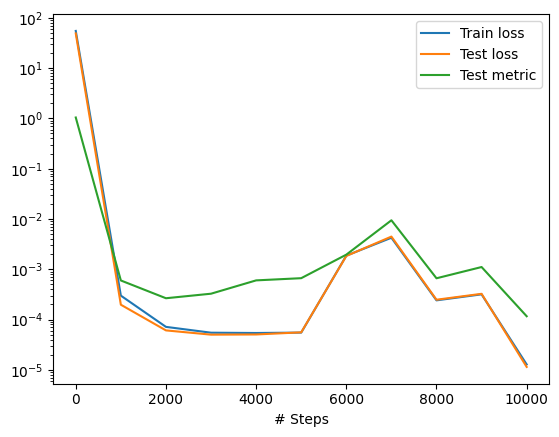

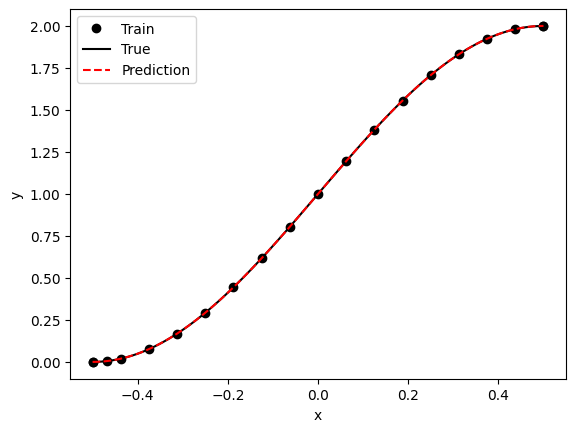

In [4]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
from deepxde.backend import tf

l = 1

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    f = (np.pi / l) ** 2 * tf.sin(np.pi / l * x)
    return - dy_xx - f


def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -l/2)


def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], l/2)


def func(x):
    return np.sin(np.pi / l * x) + 1


geom = dde.geometry.Interval(-l/2, l/2)
bc_l = dde.icbc.DirichletBC(geom, lambda X : 0 * X, boundary_l)
bc_r = dde.icbc.NeumannBC(geom, lambda X: 0 * X, boundary_r)
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)